<a href="https://colab.research.google.com/github/GIDISIA/RLDiplodatos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2021

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Código básico de importación y funciones de graficación (no modificar)

In [1]:
#@title Código básico de graficación (no modificar)

import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2l6jydkm because the default path (/home/lborgnino/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [2]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [3]:
def learn(state, action, reward, next_state, next_action, mode):
    """
    Performs a SARSA update for a given state transition
    """
    if (q.get((next_state, next_action)) == None):
        q[next_state, next_action] = 0
    if (q.get((state, action)) == None):
        q[state, action] = 0
        
    if mode == 'sarsa':
        q[state, action] = q.get((state, action)) + alpha * ((reward + gamma * (q.get((next_state, next_action))) - q.get((state, action))))
    elif mode == 'q_learn':
        for a in actions:
            if ( q.get((next_state, a)) == None ):
                q[next_state, a] = 0
                
        q_values = [q.get((next_state, a)) for a in actions]
        max_q_a = max(q_values)
        q[state, action] = q.get((state, action)) + alpha * ((reward + gamma * (max_q_a) - q.get((state, action))))
        

Finalmente, definimos el método principal de iteraciones. 

In [4]:
def run(mode = 'sarsa'):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        if ( mode == 'sarsa'):
            action = choose_action(state)
        
        while not done:

            # If mode Q learn, we select action using polict
            # derived from Q
            
            if (mode == 'q_learn'):
                action = choose_action(state)
                next_action = action
            
            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            if (mode == 'sarsa'):
                next_action = choose_action(next_state)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action, mode)
                state = next_state
                if (mode == 'sarsa'):
                    action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action, mode)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [18]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.7
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 400

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [19]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()
q = {}
avg_steps_per_episode_q, timesteps_ep_q, reward_ep_q = run(mode='q_learn')

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

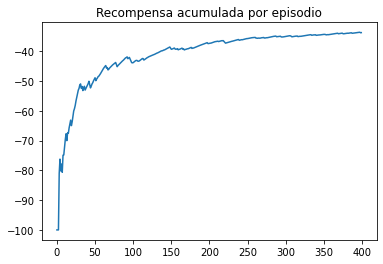

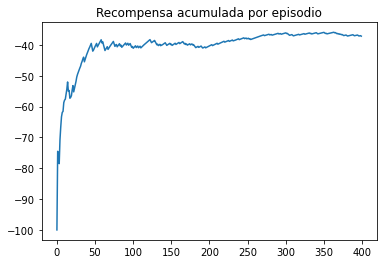

In [20]:
plot_reward_per_episode(reward_ep)
plot_reward_per_episode(reward_ep_q)

Veamos pasos por episodio

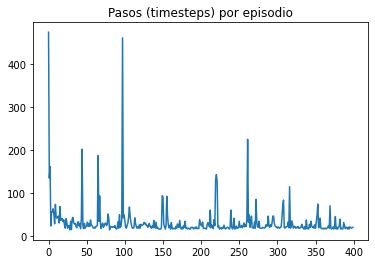

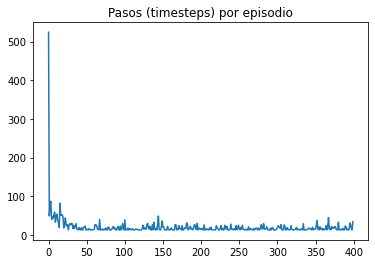

In [21]:
plot_steps_per_episode(timesteps_ep)
plot_steps_per_episode(timesteps_ep_q)

Suavizando...

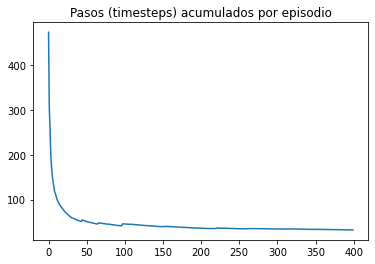

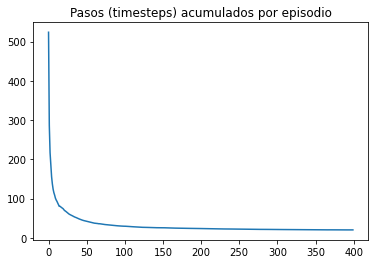

In [22]:
plot_steps_per_episode_smooth(timesteps_ep)
plot_steps_per_episode_smooth(timesteps_ep_q)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

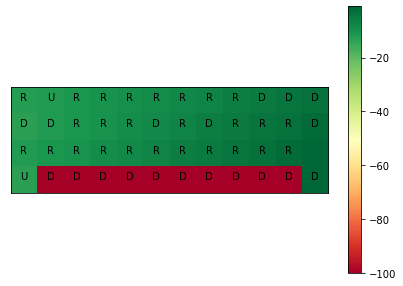


 Matriz de mejor acción-valor (en números): 

 [[ -12.50184636  -11.9         -11.10719337  -10.17114692   -9.44543775
    -8.56478249   -7.64656629   -6.84381445   -5.89297195   -4.9654778
    -3.98952658   -2.99948163]
 [ -12.9884426   -11.99783631  -10.99986183   -9.99996182   -8.99998933
    -7.99999401   -6.99999883   -5.99999953   -4.99999995   -4.
    -3.           -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [23]:
draw_value_matrix(q)

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\dot{a} \in A}e^{Q(s,\dot{a})/\tau}}$$



Para dejar el lab listo para su corrección, dejar link a repo de github con un notebook ejecutando el agente en la planilla enviada en Slack.

In [24]:
def plot_reward(reward_ep, coeffs):
    cnt = 0
    for i in reward_ep:
        episode_rewards = np.array(i)
        label = coeffs[cnt]
        cnt += 1

        # se suaviza la curva de convergencia
        episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
        acumulated_rewards = np.cumsum(episode_rewards)

        reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

        plt.plot(reward_per_episode,label="%.1f"%label)
    
    plt.title('Recompensa acumulada por episodio')
    plt.legend()
    plt.show()
    
def plot_steps(timesteps_ep, coeffs):
    cnt = 0
    # se muestra la curva de aprendizaje de los pasos por episodio
    for i in timesteps_ep:
        episode_steps = np.array(i)
        label = coeffs[cnt]
        cnt += 1
        plt.plot(np.array(range(0, len(episode_steps))), episode_steps, label="%.1f"%label)
    plt.title('Pasos (timesteps) por episodio')
    plt.legend()
    plt.show()
    
    
def plot_steps_smooth(timesteps_ep, coeffs):
    cnt = 0
    for i in timesteps_ep:
        episode_steps = np.array(i)
        label = coeffs[cnt]
        cnt += 1

        # se suaviza la curva de aprendizaje
        episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
        acumulated_steps = np.cumsum(episode_steps)

        steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

        plt.plot(steps_per_episode,label="%.1f"%label)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.legend()
    plt.show()
    

In [30]:
mode = 'q_learn'
alphas = np.arange (0.5, 0.9, 0.1)
gammas = np.arange (0.7, 1.0, 0.1)
epsilons = np.arange (0.1, 0.4, 0.1)

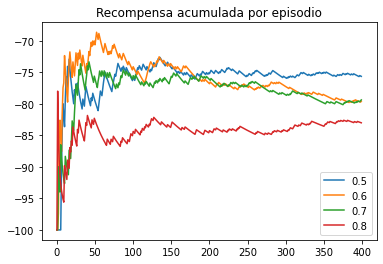

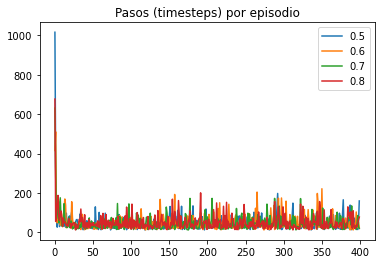

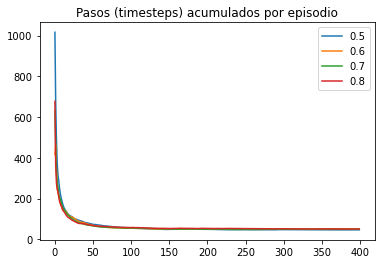

In [31]:
steps = []
timesteps = []
rewards = []

for i in alphas:
    alpha = i
    q = {}
    avg_steps_per_episode, timesteps_ep, reward_ep = run(mode)
    steps.append(avg_steps_per_episode)
    timesteps.append(timesteps_ep)
    rewards.append(reward_ep)
    
plot_reward(rewards, alphas)
plot_steps(timesteps, alphas)
plot_steps_smooth(timesteps, alphas)

    

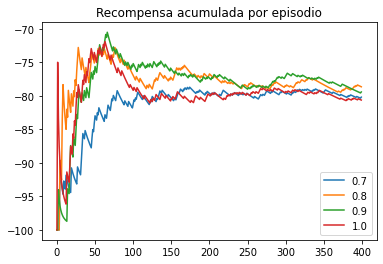

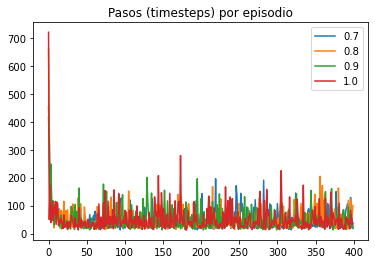

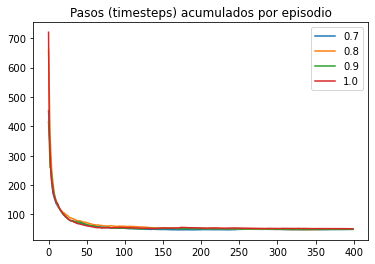

In [32]:
steps = []
timesteps = []
rewards = []

for i in gammas:
    gamma = i
    q = {}
    avg_steps_per_episode, timesteps_ep, reward_ep = run(mode)
    steps.append(avg_steps_per_episode)
    timesteps.append(timesteps_ep)
    rewards.append(reward_ep)
    
plot_reward(rewards, gammas)
plot_steps(timesteps, gammas)
plot_steps_smooth(timesteps, gammas)

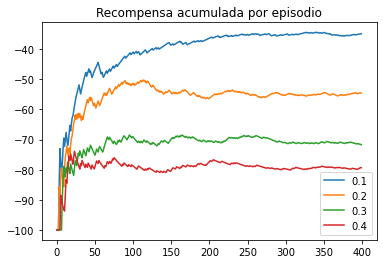

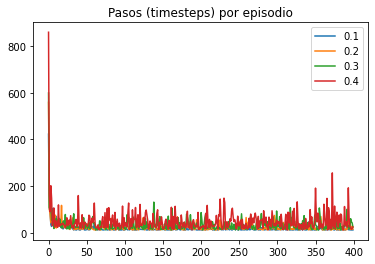

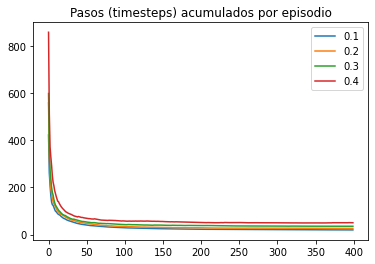

In [33]:
steps = []
timesteps = []
rewards = []

for i in epsilons:
    epsilon = i
    q = {}
    avg_steps_per_episode, timesteps_ep, reward_ep = run(mode)
    steps.append(avg_steps_per_episode)
    timesteps.append(timesteps_ep)
    rewards.append(reward_ep)
    
plot_reward(rewards, epsilons)
plot_steps(timesteps, epsilons)
plot_steps_smooth(timesteps, epsilons)

In [29]:
env.close()